<a href="https://colab.research.google.com/github/gopichandchalla16/infosys-internship-real-time-industry-insight-system/blob/anshika-dev/Project_Sprint1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Infosys Springboard Internship Project
## Real-Time Industry Insight & Strategic Intelligence System
### Sprint 1 – Data Sourcing & Handling
**Team Members:** Gopichand, Anshika, Janmejay, Vaishnavi

**Objective:** Collect, clean, and visualize real-time company or market data from external open sources.


## Step 1: Interactive User Input
We allow users to enter a **company or asset name** to fetch relevant data dynamically.


In [141]:
# User input for asset/company
asset_name = input("Enter the company name (e.g.TCS, Rakuten, Netflix): ").upper()
print(f"\nData analysis will be performed for: {asset_name}")


Enter the company name (e.g.TCS, Rakuten, Netflix): Microsoft

Data analysis will be performed for: MICROSOFT


##  Step 2: Import Required Libraries
We use the following Python libraries:
- `requests` & `BeautifulSoup` for scraping web data
- `pandas` for data manipulation
- `matplotlib` & `seaborn` for visualization
- `textblob` for sentiment analysis
- `yfinance` for market data
- `wikipedia` for Wikipedia summaries


In [142]:
# Install required libraries (run once)
!pip install yfinance textblob beautifulsoup4 lxml wikipedia feedparser faker
!pip install yfinance wikipedia beautifulsoup4 lxml feedparser transformers sentencepiece torch --quiet
!pip install tensorflow statsmodels --quiet
!pip install ipywidgets --quiet

# Import libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import yfinance as yf
import wikipedia
from bs4 import BeautifulSoup
import feedparser
from faker import Faker
import random
import datetime
import urllib.parse
from IPython.display import display, HTML, Image, clear_output
import base64


from google.colab import output
output.enable_custom_widget_manager()

# Set seaborn style
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

### Using Hugging Face’s **Transformers library** to perform sentiment analysis  with a pretrained model.

In [143]:
# HuggingFace sentiment
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

## Step 3: Fetch Wikipedia Summary
We fetch a **short summary** of the asset/company from Wikipedia for context.


In [144]:
def get_company_summary(company_name):
    try:
        # Search Wikipedia for the company
        search_results = wikipedia.search(company_name)

        if not search_results:
            return f"No Wikipedia pages found for {company_name}"

        # Keywords to detect company pages
        company_keywords = ["company", "corporation", "limited", "ltd", "group", "services", "bank", "motor", "industries", "technology"]
        global company_summary;
        # Try to find the best company-related page
        best_match = None
        for result in search_results:
            lower = result.lower()
            if any(keyword in lower for keyword in company_keywords):
                best_match = result
                break

        # If no match found, pick the first result
        if not best_match:
            best_match = search_results[0]

        # Fetch summary
        company_summary = wikipedia.summary(best_match, sentences=10)
        return company_summary

    except wikipedia.exceptions.DisambiguationError as e:
        # Pick first meaningful option
        option = e.options[0]
        company_summary = wikipedia.summary(option, sentences=10)
        return company_summary

    except Exception as e:
        return f"Error fetching summary: {e}"

# Usage:
print(get_company_summary(asset_name))


Microsoft Corporation is an American multinational technology conglomerate headquartered in Redmond, Washington. Founded in 1975, the company became influential in the rise of personal computers through software like Windows, and has since expanded to Internet services, cloud computing, artificial intelligence, video gaming, and other fields. Often described as a Big Tech company, Microsoft is the largest software maker, one of the most valuable public companies, and one of the most valuable brands globally.
Microsoft was founded by Bill Gates and Paul Allen to market BASIC interpreters for the Altair 8800. It rose to dominate the personal computer operating system market with MS-DOS in the mid-1980s, followed by Windows. During the 41 years from 1980 to 2021 Microsoft released 9 versions of MS-DOS with a median frequency of 2 years, and 13 versions of Windows with a median frequency of 3 years. The company's 1986 initial public offering (IPO) and subsequent rise in its share price cre

## Step 4: Fetch Yahoo Finance Data
We fetch **historical market data** (last 30 days) for the asset using Yahoo Finance.

In [145]:
tickers = {
    # Existing
    "NETFLIX": "NFLX",
    "APPLE": "AAPL",
    "TESLA": "TSLA",
    "GOOGLE": "GOOGL",
    "MICROSOFT": "MSFT",
    "TCS": "TCS.NS",
    "INFOSYS": "INFY.NS",
    "RAKUTEN": "RKUNY",
    "BITCOIN": "BTC-USD",

    # 🔥 Popular US Tech
    "AMAZON": "AMZN",
    "META": "META",         # Facebook
    "NVIDIA": "NVDA",
    "AMD": "AMD",
    "INTEL": "INTC",

    # 🏦 Finance
    "JP MORGAN": "JPM",
    "GOLDMAN SACHS": "GS",
    "MASTERCARD": "MA",
    "VISA": "V",

    # 🇮🇳 Common Indian Stocks
    "RELIANCE": "RELIANCE.NS",
    "HDFC": "HDFCBANK.NS",
    "ICICI": "ICICIBANK.NS",
    "WIPRO": "WIPRO.NS",
    "HCL": "HCLTECH.NS",
    "ADANIPORTS": "ADANIPORTS.NS",
    "ADANIENT": "ADANIENT.NS",

    # 🚗 Auto
    "TATA MOTORS": "TATAMOTORS.NS",
    "MARUTI": "MARUTI.NS",
    "TESLA": "TSLA",       # already above but kept for auto category

    # 🔴 Other Big Names
    "COCA COLA": "KO",
    "PEPSICO": "PEP",
    "WALMART": "WMT",
    "NETFLIX": "NFLX",     # already included

    # 💰 Other popular crypto
    "ETHEREUM": "ETH-USD",
    "DOGECOIN": "DOGE-USD",
    "SOLANA": "SOL-USD"
}

try:
    asset = tickers.get(asset_name.upper(), asset_name.upper())
    ticker = yf.Ticker(asset)
    market_data = ticker.history(period="1mo", interval="1d")

    if market_data.empty:
        raise ValueError("No data returned. Check ticker symbol.")

    market_data.reset_index(inplace=True)
    print(f"\n Market Data Sample for {asset}:")
    display(market_data.head())

except Exception as e:
    print(f"Could not fetch Yahoo Finance data: {e}")



 Market Data Sample for MSFT:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2025-10-13 00:00:00-04:00,516.409973,516.409973,511.679993,514.049988,14284200,0.0,0.0
1,2025-10-14 00:00:00-04:00,510.230011,515.280029,506.000000,513.570007,14684300,0.0,0.0
2,2025-10-15 00:00:00-04:00,514.960022,517.190002,510.000000,513.429993,14694700,0.0,0.0
3,2025-10-16 00:00:00-04:00,512.580017,516.849976,508.130005,511.609985,15559600,0.0,0.0
4,2025-10-17 00:00:00-04:00,509.040009,515.479980,507.309998,513.580017,19867800,0.0,0.0


In [146]:
from IPython.display import display, HTML
import feedparser

# Construct RSS feed URL for Google News
news_url = f"https://news.google.com/rss/search?q={asset_name}&hl=en-US&gl=US&ceid=US:en"

feed = feedparser.parse(news_url)

print(f"\n Recent News Headlines for {asset_name}:")

# Iterate through the first 10 news items (or fewer if less than 10)
for entry in feed.entries[:10]:
    display(HTML(f'{entry.title}'))
    # Display summary and source if available
    news_summary = getattr(entry, 'summary', 'N/A')
    source = getattr(entry, 'source', 'N/A')
    print(f"Summary: {news_summary}\nSource: {source.get('title', 'N/A')}\n")


 Recent News Headlines for MICROSOFT:


Summary: <a href="https://news.google.com/rss/articles/CBMiuAFBVV95cUxQSENpYjNrUVI2RGhLTzJiQUg0dWdOMURtYmRCRDZNOHRyX0pQM2x2bEZsbUMzT0g3ems4YUx3eXMwNW5UbllFVzczSUo3ekMzSEFiUURZU0c2RXYyd3RHVXBNVy04QUwtLUppVGkxUlVCZElCY01jZ3FXc0l2clR6ZjN2VGZ0NGZ6SFNlUG4yNVBzVm5VVTRNUVNFTzJ2RTVfcmhLdS02Vm9nRUhNa1VqckxkVjZPS09N?oc=5" target="_blank">Microsoft to Use OpenAI’s Custom Chip Work to Help In-House Effort</a>&nbsp;&nbsp;<font color="#6f6f6f">Bloomberg.com</font>
Source: Bloomberg.com



Summary: <ol><li><a href="https://news.google.com/rss/articles/CBMiwAFBVV95cUxQQXdtMWI1VFUyckJsZE55RWQ3cmU2TEt6cGdHb3M3NFJTc1M2OXJIeXk5TFcwaDRiRGhmbUVOZjBEdFdOQ3dSZUVDUFVxejVURFgyTjlGazhqYVZ6RVNhRGtrV2ZmQWF3eGJmaUdnc3E1end0cGl3cThYU1QtTjJ0YjFuTGd3bzlBNGswSUR5aGxudmEya3liUVRiQXptZFNJOTNiQTVtVW9TbnRCV24ybTJRcmVKZEdDcWFsY0RIenA?oc=5" target="_blank">Microsoft launches Atlanta Fairwater AI data center - two stories, no UPS or gen-sets</a>&nbsp;&nbsp;<font color="#6f6f6f">Data Center Dynamics</font></li><li><a href="https://news.google.com/rss/articles/CBMitwNBVV95cUxPSFVVRkJBbXctTlRaM1ZxZXhVYWJ2dXNqdS1jMVZrbGJpcEtiekhqT09sc3NCb1JHeFdkVEg4ZmRNRHZWdmxDX2ZIM1Q5V3l4TWZqaFNBZU1CbU5hdGdTMFBPZnRsNG9uQVQ5eGtiak5rVlZRaGRXQzFKMFhfZE42VHRjNXpoRXRiV0Fkek1zV2p4cTlMMWE4QnEtaXdMN2ZodlhrVnkyV0tPMm9rQ0FqY0ZWNXdvdmlQSVhTbjZOck5yWElacy1faDBuVXhlZGRLS2hWM3l3bUdjY1NNVWFycmhNMzJrZXpnMjdBMHo5QkdpSm9xaEk2bzRiMzB0WkJPYkx1MUloRVVIY0lxRXFBbDJ1TVNwOW1MOUZwTnFZUTZIYXhNU0hiQ3AwdVdWajhIb3kxV0EtRHF2QTJUX1NRXzgtUFEwdjJzTk

Summary: <a href="https://news.google.com/rss/articles/CBMihgFBVV95cUxNMW54Mk4wbTBlTlplbTBPeE1XVUtvNmRBMmpxNFBwY2FJaHUyODJXNlJxTzVQdkk2eVc1MnlzRnZBa25UUGRSNWVnZnZnWWJ3Y2V3Qkg2eGhsaUdiQzdrTWhpQnVnUWtGaTVQTXkwc0F5WHFDcjNoZGlXbUVNeS1UTi1QWlZRUQ?oc=5" target="_blank">EPAM Wins the 2025 Microsoft Innovate with Azure AI Platform Partner of the Year Award</a>&nbsp;&nbsp;<font color="#6f6f6f">Yahoo Finance</font>
Source: Yahoo Finance



Summary: <a href="https://news.google.com/rss/articles/CBMingFBVV95cUxPVzZMeVMzTnRMdW9nSGNOZ05OSkNyb3VyeHJ1djRnQnMxUHpQS2J6LUV4QnMtR3ozUkNyTjJuTEdsVldhSEh4UzN0aThMRUh4Q3BEX25qaDI1d0d6bUR5WGhKLXp3eEhwYjU0MF94cjJIX2hjeUp1dUZXdGZLb2pPTVM5Q25hWHZhb2RJTklod3NRVFdpTEU2aGZ6bHFtdw?oc=5" target="_blank">Valve just built the Xbox that Microsoft is dreaming of</a>&nbsp;&nbsp;<font color="#6f6f6f">The Verge</font>
Source: The Verge



Summary: <a href="https://news.google.com/rss/articles/CBMiggFBVV95cUxPNWhWc2xjVXRuTjZkczhmTnl1akdxMDJzYmprUHRnQmRxVnFaMElQRkZCOThnVXZ1dEhoYTdwSXh5bXFfcmVoTEI0MzIxbVlsS2pWdEZxRU9yb3MxcWdFaS00b1cteDZLYll1Vjh4R2RMWW5qVGpuLTJ2amVQS184OERB?oc=5" target="_blank">How Microsoft dealt with compatibility issues in Windows 95</a>&nbsp;&nbsp;<font color="#6f6f6f">theregister.com</font>
Source: theregister.com



Summary: <a href="https://news.google.com/rss/articles/CBMitgFBVV95cUxQbTZHRlZQbk5Ba1VIUEhzQ1FLc1ZISXRoSnV0YUpqMlJBWGxoZkpJNENWUWNIblRpb1V0MHFXUzZtRW1EWlFPWm9USGlXclBsRWlvbHpGanp5OGV2X1FrX20ydWpOZnNWTFpON2hyejgtNGxDMmMySzRtaVJzLUtSOThRMzF3TEdmam5sMTNtS3VxQVJwejdFOGt3WTctQWg3cDhMTE5Xa3RvQVFFTHJNMWdhVDY1UQ?oc=5" target="_blank">Microsoft releases update-fixing update for update-eligible Windows 10 PCs</a>&nbsp;&nbsp;<font color="#6f6f6f">Ars Technica</font>
Source: Ars Technica



Summary: <a href="https://news.google.com/rss/articles/CBMivAFBVV95cUxOVy1XdkpHR2lBN2JCbllxdWtPVWJIbnY2NUlqTmdrdUdQNU9NM2dpR0pVUHlmRGtpbmhJbmRtNFpWX1dJN29LY2RYbndqSUltaDV6ZWxBa0l2M1UxdjdLOUk2Z2MzRlctd3hQck9LUlRWYndFZEp6SjlVYUNUSjlmUmMxc2I0d1hJQ002TFFRNkY5bnNkcHVYUlQ0MElOVW1qRGlRb1E2UmpjeTJQcVVVOG41YnBXRkFnOTFESg?oc=5" target="_blank">New Microsoft Alert — Update Windows 10 And 11 Now, Attacks Underway</a>&nbsp;&nbsp;<font color="#6f6f6f">Forbes</font>
Source: Forbes



Summary: <a href="https://news.google.com/rss/articles/CBMiwAFBVV95cUxNREV1ZXF6VDZEbkZKNVVZWUxkTjdHenMwd2VDVmF1N0VlZXBpa0ZmcVlXYWpVOVptdTd4el9BTFVSd2RWY0NuLW9Bb2FBQjFSODBhd1lRVEQ0TnpyNTBmUmNQV0FQMFMtcG1vWURLMWV1UUFCSDNrZTJyWlBQOVZYWlFIQVQ2QUpVeXMxVkFHM3BRYlpIaTB2dThyYnA3aVptbDNkalVKdlFjcWhsYjhndnB6RjladUNxREZKMG9GRErSAcYBQVVfeXFMT0t0NF9mMGxXNG5XZHpONDNmTUhTVDNEUkpJUFhibGtOTzJpZW9TZ3puLUlUOXFaOUxkQ3BuVmpQQmtUOUtabEJTN3RVQW1MeFVHV1FkaksxR3RqeXJicE5BeU5QNklTOVZQbkxoMDJLOWM0aVRjWE5wZjZFZlZVYWk0dlBwbU5nb19ieTFfMU1zUkp5QmYzcmhEcF8tRjltc3NOODZTMmY0QVctWHd0QTNxWGxtQ0N5Y2FuS0J6c01hMWR0bXVR?oc=5" target="_blank">Microsoft releases KB5068781 — The first Windows 10 extended security update</a>&nbsp;&nbsp;<font color="#6f6f6f">BleepingComputer</font>
Source: BleepingComputer



Summary: <a href="https://news.google.com/rss/articles/CBMiuwFBVV95cUxOQjZXVE5CXzhuakZsZTRMZE1TVTNhZDZpWmhhOWxOMmw5VWVHckdHVVVzYTRBUlVZVDV2ekFEWndUQU9ZaThvbWQ2cDkxMm8tV1laano5WVlRV1NnMTV5Y3JxbEw5b2ZRZHh1UHFVZ1VxSjJ1Q1o5X0I5aTlDVEw4VVkwajFYRmxEaHJqVm5yckFrT0drVE9qa0JEWmxEVFB0bWNGVDd5ckg1OXZldFItT21uLU5uRGlhSGZF?oc=5" target="_blank">Microsoft’s plan to fix its chip problem is, partly, to let OpenAI do the heavy lifting</a>&nbsp;&nbsp;<font color="#6f6f6f">TechCrunch</font>
Source: TechCrunch



Summary: <a href="https://news.google.com/rss/articles/CBMimgFBVV95cUxQLU9SQjFEOFJiOFNJQ3QtN2lxSVdGYi1uNzNvNTBoUVdld1ZFV3cwemIwS3libjVVR3pfcFF4S2JRaE1PRGFuNWR6S1QzVkY1cTEzTFV6MEI4WTZfQlp2RVAwa1JXcWJ4RjBuaW5VM2hoUU9zbGlPN2lGVThvQzhyUFNiYzhyamk0UXctVXRKWGJUeVNKbjgxd29n?oc=5" target="_blank">Microsoft will use OpenAI custom chip effort to inform its own</a>&nbsp;&nbsp;<font color="#6f6f6f">Fortune</font>
Source: Fortune



## Step 5: Fetch Google News Headlines via RSS
We fetch **recent news headlines** about the asset using Google News RSS.


In [147]:
# Construct RSS feed URL for Google News
company_name=asset_name.replace(" ", "");
rss_url = f"https://news.google.com/rss/search?q={company_name}&hl=en-US&gl=US&ceid=US:en"
global news_items
feed = feedparser.parse(rss_url)
news_items = [{"Title": entry.title, "Link": entry.link, "Published": entry.published} for entry in feed.entries[:10]]
titles = [item["Title"] for item in news_items]
links = [item["Link"] for item in news_items]
news_df = pd.DataFrame(news_items)
print(f"\n Top 10 News Headlines for {asset_name}:")
display(news_df)


 Top 10 News Headlines for MICROSOFT:


,Title,Link,Published
0,Microsoft to Use OpenAI’s Custom Chip Work to ...,https://news.google.com/rss/articles/CBMiuAFBV...,"Wed, 12 Nov 2025 21:34:22 GMT"
1,Microsoft launches Atlanta Fairwater AI data c...,https://news.google.com/rss/articles/CBMiwAFBV...,"Wed, 12 Nov 2025 19:05:22 GMT"
2,EPAM Wins the 2025 Microsoft Innovate with Azu...,https://news.google.com/rss/articles/CBMihgFBV...,"Thu, 13 Nov 2025 13:02:00 GMT"
3,Valve just built the Xbox that Microsoft is dr...,https://news.google.com/rss/articles/CBMingFBV...,"Thu, 13 Nov 2025 13:00:00 GMT"
4,How Microsoft dealt with compatibility issues ...,https://news.google.com/rss/articles/CBMiggFBV...,"Thu, 13 Nov 2025 13:30:00 GMT"
5,Microsoft releases update-fixing update for up...,https://news.google.com/rss/articles/CBMitgFBV...,"Wed, 12 Nov 2025 20:38:01 GMT"
6,New Microsoft Alert — Update Windows 10 And 11...,https://news.google.com/rss/articles/CBMivAFBV...,"Wed, 12 Nov 2025 14:13:48 GMT"
7,Microsoft releases KB5068781 — The first Windo...,https://news.google.com/rss/articles/CBMiwAFBV...,"Tue, 11 Nov 2025 19:09:57 GMT"
8,"Microsoft’s plan to fix its chip problem is, p...",https://news.google.com/rss/articles/CBMiuwFBV...,"Thu, 13 Nov 2025 12:01:20 GMT"
9,Microsoft will use OpenAI custom chip effort t...,https://news.google.com/rss/articles/CBMimgFBV...,"Thu, 13 Nov 2025 10:51:46 GMT"


## Step 6: Generate Synthetic Tweets
We generate **50 realistic tweets** using `Faker` and random sentiment phrases for demonstration.


In [148]:
from faker import Faker
import random
import pandas as pd

fake = Faker()

# Fix: properly close the list after 'else'
texts = [n["Title"] for n in news_items] if news_items else [
    fake.sentence(nb_words=6) for _ in range(10)
]

positive_phrases = [
    f"{company_name} is surging!",
    f"Profits from {company_name} are amazing!",
    f"Holding {company_name} long-term, confident.",
    f"{company_name} adoption is growing worldwide!",
    f"Investors are optimistic about {company_name}."
]

negative_phrases = [
    f"Worried about {company_name} volatility.",
    f"{company_name} might crash soon.",
    f"{company_name}'s future is uncertain.",
    f"High risks in {company_name} investments.",
    f"{company_name} energy consumption is concerning."
]

neutral_phrases = [
    f"{company_name} price remains stable today.",
    f"Market watching {company_name} closely.",
    f"{company_name} updates coming soon.",
    f"{company_name} performance unchanged.",
    f"Analysts report on {company_name} today."
]

tweets = []
for _ in range(50):
    sentiment_choice = random.choices(
        ["positive", "negative", "neutral"], weights=[0.4, 0.3, 0.3]
    )[0]
    if sentiment_choice == "positive":
        tweets.append(random.choice(positive_phrases))
    elif sentiment_choice == "negative":
        tweets.append(random.choice(negative_phrases))
    else:
        tweets.append(random.choice(neutral_phrases))

tweets_df = pd.DataFrame(tweets, columns=["Tweet"])

# Display output based on the data source used
if news_items:
    print(f"\nPerforming sentiment analysis on {len(texts)} news items:\n")
    for i, text in enumerate(texts, 1):
        print(f"{i}. {text}")
else:
    print(f"\nPerforming sentiment analysis on {len(tweets_df)} generated tweets:\n")
    print(tweets_df)



Performing sentiment analysis on 10 news items:

1. Microsoft to Use OpenAI’s Custom Chip Work to Help In-House Effort - Bloomberg.com
2. Microsoft launches Atlanta Fairwater AI data center - two stories, no UPS or gen-sets - Data Center Dynamics
3. EPAM Wins the 2025 Microsoft Innovate with Azure AI Platform Partner of the Year Award - Yahoo Finance
4. Valve just built the Xbox that Microsoft is dreaming of - The Verge
5. How Microsoft dealt with compatibility issues in Windows 95 - theregister.com
6. Microsoft releases update-fixing update for update-eligible Windows 10 PCs - Ars Technica
7. New Microsoft Alert — Update Windows 10 And 11 Now, Attacks Underway - Forbes
8. Microsoft releases KB5068781 — The first Windows 10 extended security update - BleepingComputer
9. Microsoft’s plan to fix its chip problem is, partly, to let OpenAI do the heavy lifting - TechCrunch
10. Microsoft will use OpenAI custom chip effort to inform its own - Fortune


## Step 7: Preprocess Tweets & Perform Sentiment Analysis
We analyze the **polarity** of each tweet using `ProsusAI/finbert model` and classify them into Positive, Negative, or Neutral.


In [149]:
import numpy as np
#Financial NLP model

model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
hf_model = AutoModelForSequenceClassification.from_pretrained(model_name)

labels = ["Negative", "Neutral", "Positive"]



def finbert_sentiment(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
    with torch.no_grad():
        out = hf_model(**tokens)
    probs = torch.softmax(out.logits, dim=1).cpu().numpy()[0]
    sentiment = labels[int(np.argmax(probs))]
    return sentiment, probs

# ✅ Generate sentiment rows
sent_rows = []
for t in texts:
    s_label, s_probs = finbert_sentiment(t)
    sent_rows.append({
        "text": t,
        "sentiment": s_label,
        "neg": float(s_probs[0]),
        "neu": float(s_probs[1]),
        "pos": float(s_probs[2]),
    })

# ✅ Final Sentiment DataFrame
global sent_df
sent_df = pd.DataFrame(sent_rows)
# display(sent_df)

# ----- DARK MODE SENTIMENT TABLE UI -----

def color_row(sentiment):
    if sentiment == "Positive":
        return "background:rgba(0,255,150,0.18); border-left:4px solid #00ff88;"
    elif sentiment == "Negative":
        return "background:rgba(255,0,80,0.18); border-left:4px solid #ff0055;"
    else:
        return "background:rgba(255,255,255,0.10); border-left:4px solid #bbbbbb;"

html_rows = ""

for _, row in sent_df.iterrows():
    html_rows += f"""
        <tr style="{color_row(row['sentiment'])}; padding:10px;">
            <td style="padding:12px; color:#eee;">{row['text'][:120]}...</td>
            <td style="padding:12px; color:#00eaff; font-weight:600;">{row['sentiment']}</td>
            <td style="padding:12px; color:#ff6666;">{row['neg']:.2f}</td>
            <td style="padding:12px; color:#cccccc;">{row['neu']:.2f}</td>
            <td style="padding:12px; color:#00ff88;">{row['pos']:.2f}</td>
        </tr>
    """

sent_table_html = f"""
<div style="
    padding:20px;
    background:rgba(20,20,25,0.75);
    border-radius:18px;
    border:1px solid #333;
    box-shadow:0 0 30px rgba(0,255,255,0.15);
    color:white;
    font-family:Segoe UI;
    width:90%;
">
    <h2 style="color:#00eaff; margin-top:0;">🧠 HuggingFace Sentiment Analysis</h2>

    <table style="width:100%; border-collapse:collapse; font-size:15px;">
        <thead>
            <tr style="background:#111;">
                <th style="padding:12px; color:#00eaff; text-align:left;">Text</th>
                <th style="padding:12px; color:#00eaff; text-align:left;">Sentiment</th>
                <th style="padding:12px; color:#00eaff;">Neg</th>
                <th style="padding:12px; color:#00eaff;">Neu</th>
                <th style="padding:12px; color:#00eaff;">Pos</th>
            </tr>
        </thead>
        <tbody>
            {html_rows}
        </tbody>
    </table>
</div>
"""

display(HTML(sent_table_html))




Text,Sentiment,Neg,Neu,Pos
Microsoft to Use OpenAI’s Custom Chip Work to Help In-House Effort - Bloomberg.com...,Positive,0.15,0.01,0.84
"Microsoft launches Atlanta Fairwater AI data center - two stories, no UPS or gen-sets - Data Center Dynamics...",Positive,0.02,0.02,0.95
EPAM Wins the 2025 Microsoft Innovate with Azure AI Platform Partner of the Year Award - Yahoo Finance...,Negative,0.92,0.01,0.07
Valve just built the Xbox that Microsoft is dreaming of - The Verge...,Positive,0.10,0.01,0.89
How Microsoft dealt with compatibility issues in Windows 95 - theregister.com...,Positive,0.04,0.12,0.84
Microsoft releases update-fixing update for update-eligible Windows 10 PCs - Ars Technica...,Positive,0.06,0.02,0.92
"New Microsoft Alert — Update Windows 10 And 11 Now, Attacks Underway - Forbes...",Positive,0.04,0.09,0.87
Microsoft releases KB5068781 — The first Windows 10 extended security update - BleepingComputer...,Positive,0.04,0.03,0.94
"Microsoft’s plan to fix its chip problem is, partly, to let OpenAI do the heavy lifting - TechCrunch...",Positive,0.08,0.01,0.90
Microsoft will use OpenAI custom chip effort to inform its own - Fortune...,Positive,0.13,0.01,0.86


## Step 8: Visualize Sentiment Distribution
We create a **bar chart** showing how many tweets fall into each sentiment category.

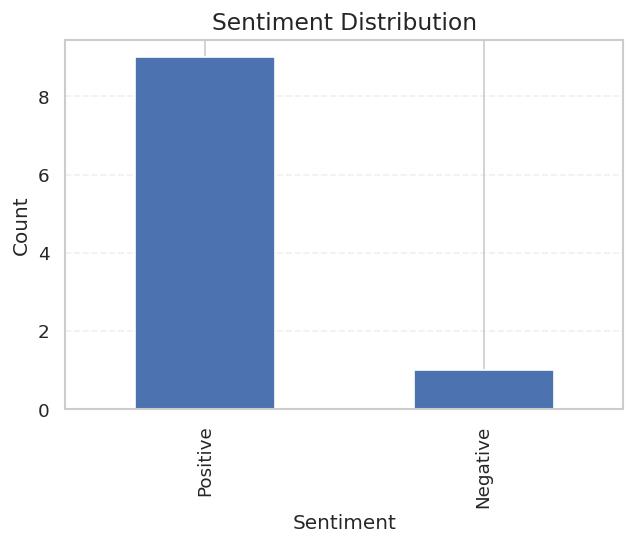

In [150]:
# plt.figure(figsize=(6,4))
# sns.countplot(data=tweets_df, x="Sentiment", hue="Sentiment", palette="viridis", legend=False)
# plt.title(f"Sentiment Distribution for {company_name} Tweets")
# plt.xlabel("Sentiment")
# plt.ylabel("Tweet Count")
# plt.show()

plt.figure(figsize=(6,4))
sent_df['sentiment'].value_counts().plot(kind='bar', edgecolor='white')
plt.title("Sentiment Distribution", fontsize=14)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()




## Step 9: Visualize Sentiment Trend Across Tweets
We create a **line chart** showing polarity trend across the 50 tweets.


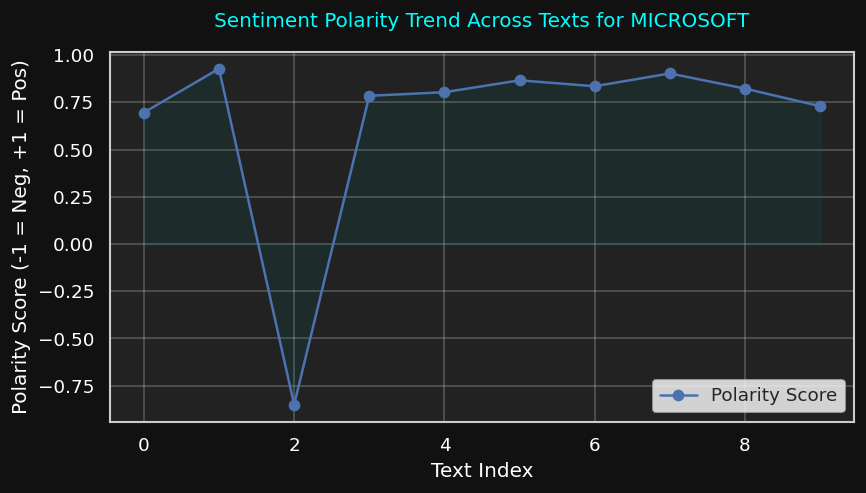

In [151]:
# plt.figure(figsize=(8,4))
# plt.plot(tweets_df.index, tweets_df["Polarity"], marker='o', linestyle='-', color='teal')
# plt.title(f"Sentiment Polarity Trend Across Tweets for {company_name}")
# plt.xlabel("Tweet Index")
# plt.ylabel("Polarity Score")
# plt.grid(True)
# plt.show()

sent_df["polarity_score"] = (
    sent_df["pos"] * 1 + sent_df["neu"] * 0 + sent_df["neg"] * -1
)
# Plot polarity trend
plt.figure(figsize=(8, 4))
plt.plot(
    range(len(sent_df)),
    sent_df["polarity_score"],
    marker="o",
    linestyle="-",
    label="Polarity Score"
)
plt.fill_between(
    range(len(sent_df)),
    sent_df["polarity_score"],
    color="teal",
    alpha=0.1
)

plt.title(f"Sentiment Polarity Trend Across Texts for {company_name}", color="cyan", pad=15)
plt.xlabel("Text Index", color="white")
plt.ylabel("Polarity Score (-1 = Neg, +1 = Pos)", color="white")
plt.grid(True, alpha=0.3)
plt.legend()
plt.gcf().patch.set_facecolor("#111")
plt.gca().set_facecolor("#222")
plt.tick_params(colors="white")
plt.show()


## Step 10: Visualize Market Price Trend
For context, we visualize the closing price of the asset over the last 30 days.


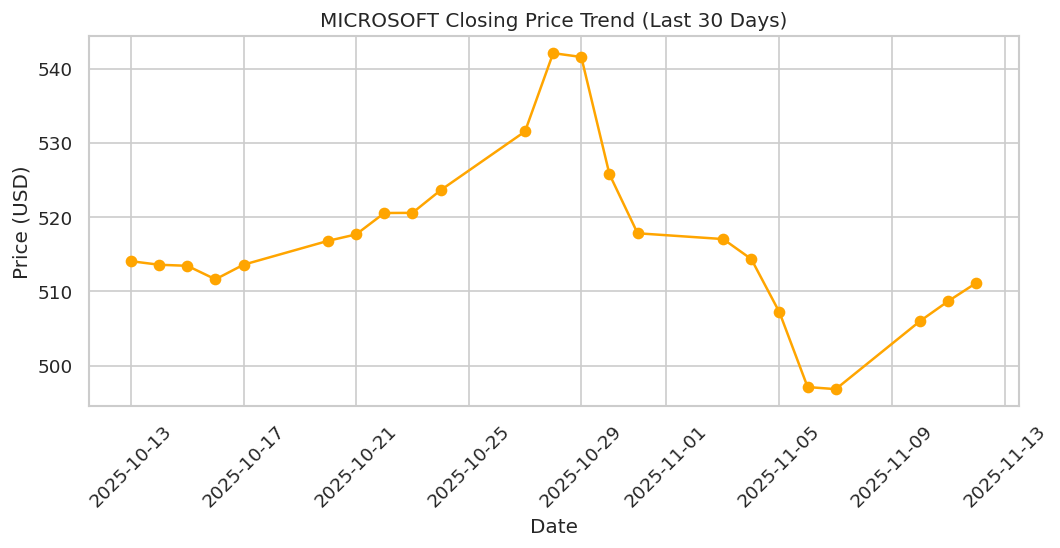

In [152]:
plt.figure(figsize=(10,4))
plt.plot(market_data["Date"], market_data["Close"], marker='o', color='orange')
plt.title(f"{company_name} Closing Price Trend (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Using Alpha Vantage for Stock Data


First, install the library:

In [153]:
!pip install alpha_vantage

### Analyze Alpha Vantage Data
Here are some descriptive statistics for the Alpha Vantage data:

In [154]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
from google.colab import userdata

API_KEY = userdata.get('ALPHA_VANTAGE_API')
def detect_symbol(asset_name: str) -> str:
    """
    Maps common company/asset names to their typical stock or crypto symbols.
    If no match is found, the name itself is returned as the potential symbol.
    """
    mapping = {
    "BITCOIN": "BTCUSD",
    "BTC": "BTCUSD",

    "TESLA": "TSLA",
    "TSLA": "TSLA",

    "NETFLIX": "NFLX",
    "NFLX": "NFLX",

    "INFOSYS": "INFY",
    "INFY": "INFY",

    "TCS": "TCS",
    "TATA CONSULTANCY": "TCS",

    "RAKUTEN": "RKUNY",

    # ✅ Common U.S. tech
    "APPLE": "AAPL",
    "AAPL": "AAPL",

    "GOOGLE": "GOOG",
    "ALPHABET": "GOOG",
    "GOOG": "GOOG",

    "MICROSOFT": "MSFT",
    "MSFT": "MSFT",

    "AMAZON": "AMZN",
    "AMZN": "AMZN",

    "NVIDIA": "NVDA",
    "NVDA": "NVDA",

    "META": "META",
    "FACEBOOK": "META",

    # ✅ More popular tickers
    "AMD": "AMD",
    "INTEL": "INTC",
    "COCA COLA": "KO",
    "PEPSICO": "PEP",
    "WALMART": "WMT",

    # ✅ Indian stocks (BSE/NSE)
    "RELIANCE": "RELIANCE.BSE",
    "HDFC": "HDFC.BSE",
    "ICICI": "ICICIBANK.BSE",
    "WIPRO": "WIPRO.BSE",
    "HCL": "HCLTECH.BSE",

    # ✅ Crypto
    "ETHEREUM": "ETHUSD",
    "ETH": "ETHUSD",
    "DOGE": "DOGEUSD",
    "DOGECOIN": "DOGEUSD",
    "SOLANA": "SOLUSD",
    "SOL": "SOLUSD",
}

    # Return the mapped symbol or the original name (converted to uppercase for robustness)
    return mapping.get(asset_name.upper(), asset_name.upper())

    # --- Core Trend Analysis Logic ---
def get_trend(df: pd.DataFrame) -> tuple[str, str]:
    """
    Calculates 20-day and 50-day Simple Moving Averages (SMA) to determine
    the market trend (Bullish, Bearish, or Sideways).
    The '4. close' column is used for calculations.
    """
    df = df.copy()

    # Check for minimum data requirement for a reliable 50-day SMA
    if len(df) < 50:
        return "⚠️ Insufficient Data", "Cannot calculate trend (needs at least 50 days of data)"

    # Calculate SMAs
    # Note: rolling() automatically aligns the mean to the end of the window
    df['SMA20'] = df['4. close'].rolling(window=20).mean()
    df['SMA50'] = df['4. close'].rolling(window=50).mean()

    # Get the latest calculated values
    latest = df.iloc[-1]

    # Handle potential NaN values (occurs if the window is not yet full)
    if pd.isna(latest['SMA20']) or pd.isna(latest['SMA50']):
         return "⚠️ Data Not Yet Complete", "Need more data points for rolling average calculation"

    # Compare SMAs (Golden Cross / Death Cross strategy)
    if latest['SMA20'] > latest['SMA50']:
        return "✅ Bullish Trend", "The short-term trend (SMA20) is above the long-term trend (SMA50). Potential Uptrend."
    elif latest['SMA20'] < latest['SMA50']:
        return "❌ Bearish Trend", "The short-term trend (SMA20) is below the long-term trend (SMA50). Potential Downtrend."
    else:
        return "↔️ Sideways Market", "SMAs are crossing or are too close. Neutral — Wait for a breakout."

# --- Main Execution Block ---
def run_analysis():
    """
    Main function to ask for user input, fetch data, and print the analysis.
    """
    if not API_KEY:
        print("\n❌ Error: ALPHA_VANTAGE_API_KEY is not configured.")
        print("Please set the 'ALPHA_VANTAGE_API_KEY' secret in your environment.")
        return

    # --- ASK USER ---
    try:
        # company_name = input("Enter the company name (e.g., Infosys, Rakuten, Netflix, TCS): ")
        company_name=asset_name
    except EOFError:
        # Handle non-interactive environments by using a default
        company_name = "TESLA"
        print(f"Non-interactive environment detected. Using default company: {company_name}")


    if not company_name:
        print("Analysis cancelled: Company name cannot be empty.")
        return

    print(f"\nData analysis will be performed for: {company_name}")

    # --- SYMBOL DETECTION ---
    global symbol
    symbol = detect_symbol(company_name)
    print(f"Using symbol: {symbol}")

    # --- FETCH & PROCESS ---
    try:
        # Initialize the TimeSeries client
        # output_format='pandas' is essential for DataFrame operations
        ts = TimeSeries(key=API_KEY, output_format='pandas')
        global data
        # Fetch daily data (compact size fetches 100 data points, good for 50-day SMA)
        data, meta = ts.get_daily(symbol=symbol, outputsize='compact')
        # Alpha Vantage returns data newest-first, so sort the index (date) oldest-first
        data = data.sort_index()
        # print(data)

        print(f"\n📊 Latest Market Data for {company_name} ({symbol}):")
        # Display the last 3 days of data for review
        print(data[['4. close']].tail(3).to_markdown(numalign="left", stralign="left"))
        global trend, decision
        # Perform the trend analysis
        trend, decision = get_trend(data)

        # Output the results
        print("\n--- Analysis Result ---")
        print(f"Asset: {company_name} ({symbol})")
        print(f"📌 Trend Status: {trend}")
        print(f"🧾 Decision: {decision}")
        print("-----------------------")

    except ValueError as ve:
        # Alpha Vantage throws ValueError on invalid symbol or API key issues
        print(f"\n❌ Error fetching data for {company_name} ({symbol}):")
        print(f"    Details: {ve}")
        print("    Suggestion: Check if the symbol is correct and if the API key is valid.")

    except Exception as e:
        print(f"\n❌ An unexpected error occurred: {e}")

if __name__ == "__main__":
    run_analysis()


Data analysis will be performed for: MICROSOFT
Using symbol: MSFT

📊 Latest Market Data for MICROSOFT (MSFT):
| date                | 4. close   |
|:--------------------|:-----------|
| 2025-11-10 00:00:00 | 506        |
| 2025-11-11 00:00:00 | 508.68     |
| 2025-11-12 00:00:00 | 511.14     |

--- Analysis Result ---
Asset: MICROSOFT (MSFT)
📌 Trend Status: ✅ Bullish Trend
🧾 Decision: The short-term trend (SMA20) is above the long-term trend (SMA50). Potential Uptrend.
-----------------------


Now, let's visualize the closing price over time:



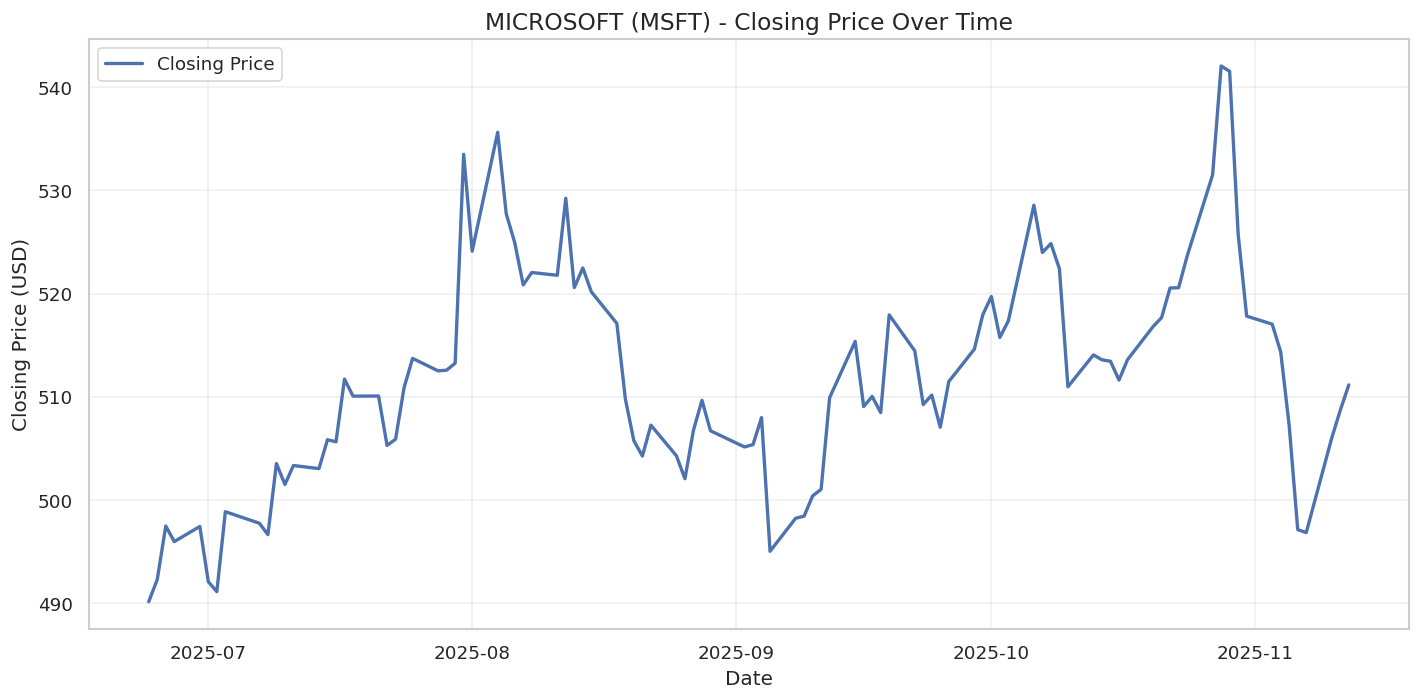

In [155]:
# Ensure data exists
if 'data' in locals() and not data.empty:
  plt.figure(figsize=(12,6))
  plt.plot(data.index, data['4. close'], label='Closing Price', linewidth=2)

  plt.title(f"{company_name} ({symbol}) - Closing Price Over Time", fontsize=14)
  plt.xlabel("Date", fontsize=12)
  plt.ylabel("Closing Price (USD)", fontsize=12)
  plt.legend()
  plt.grid(True, alpha=0.3)
  plt.tight_layout()
  plt.show()
else:
    print("No data available to visualize. Please run the data fetch cell first.")

In [156]:
import plotly.graph_objects as go
# Ensure data is available
if 'data' in locals() and not data.empty:
    fig = go.Figure(data=[
        go.Candlestick(
            x=data.index,
            open=data['1. open'],
            high=data['2. high'],
            low=data['3. low'],
            close=data['4. close'],
            name=f"{company_name}"
        )
    ])

    fig.update_layout(
        title=f"{company_name} ({symbol}) - Candlestick Chart",
        xaxis_title="Date",
        yaxis_title="Price (USD)",
        xaxis_rangeslider_visible=False,
        template="plotly_white",
        width=950,
        height=550
    )

    fig.show()
else:
    print("No data available to visualize. Please run the data fetch cell first.")


# Sprint 1 Conclusion
**What we achieved in Sprint 1:**

1. Collected real-time open-source data from:


* Wikipedia (summary)
* Yahoo Finance (market prices)
* Google News RSS (recent headlines)
* Generated synthetic tweets (50) for sentiment analysis

2. Cleaned and structured data using **pandas DataFrames**
3. Performed sentiment analysis using **TextBlob**

4. Visualized key insights:
* Sentiment distribution (bar chart)
* Sentiment trend across tweets (line chart)
* Market price trend (line chart)

5. Built a flexible, interactive notebook for any asset/company input

This notebook sets the foundation for Sprint 2, where we will integrate real-time dashboards and AI-driven analytics.

In [157]:
import numpy as np
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

In [158]:
def card(title, content):
    html = f"""
    <div style='border:1px solid #ddd;border-radius:10px;padding:15px;margin:10px;
                background:beige;font-family:sans-serif;color:black;'>
        <h3 style='text-align:center; color:black'>{title}</h3>
        <p style='line-height:1.5; font-color:white;'>{content}</p>
    </div>
    """
    display(HTML(html))


Headline,Link
Microsoft to Use OpenAI’s Custom Chip Work to Help In-House Effort - Bloomberg.com,Read More
"Microsoft launches Atlanta Fairwater AI data center - two stories, no UPS or gen-sets - Data Center Dynamics",Read More
EPAM Wins the 2025 Microsoft Innovate with Azure AI Platform Partner of the Year Award - Yahoo Finance,Read More
Valve just built the Xbox that Microsoft is dreaming of - The Verge,Read More
How Microsoft dealt with compatibility issues in Windows 95 - theregister.com,Read More
Microsoft releases update-fixing update for update-eligible Windows 10 PCs - Ars Technica,Read More
"New Microsoft Alert — Update Windows 10 And 11 Now, Attacks Underway - Forbes",Read More
Microsoft releases KB5068781 — The first Windows 10 extended security update - BleepingComputer,"<a href=""https://news.google.com/rss/articles/CBMiwAFBVV95cUxNREV1ZXF6VDZEbkZKNVVZWUxkTjdHenMwd2VDVmF1N0VlZXBpa0ZmcVlXYWpVOVptdTd4el9BTFVSd2RWY0NuLW9Bb2FBQjFSODBhd1lRVEQ0TnpyNTBmUmNQV0FQMFMtcG1vWURLMWV1UUFCSDNrZTJyWlBQOVZYWlFIQVQ2QUpVeXMxVkFHM3BRYlpIaTB2dThyYnA3aVptbDNkalVKdlFjcWhsYjhndnB6RjladUNxREZKMG9GRErSAcYBQVVfeXFMT0t0NF9mMGxXNG5XZHpONDNmTUhTVDNEUkpJUFhibGtOTzJpZW9TZ3puLUlUOXFaOUxkQ3BuVmpQQmtUOUtabEJTN3RVQW1MeFVHV1FkaksxR3RqeXJicE5BeU5QNklTOVZQbkxoMDJLOWM0aVRjWE5wZjZFZlZVYWk0dlBwbU5nb19ieTFfMU1zUkp5QmYzcmhEcF8tRjltc3NOODZTMmY0QVctWHd0QTNxWGxtQ0N5Y2FuS0J6c01hMWR0bXVR?oc=5"" target=""_blank"">Read More"
"Microsoft’s plan to fix its chip problem is, partly, to let OpenAI do the heavy lifting - TechCrunch",Read More
Microsoft will use OpenAI custom chip effort to inform its own - Fortune,Read More


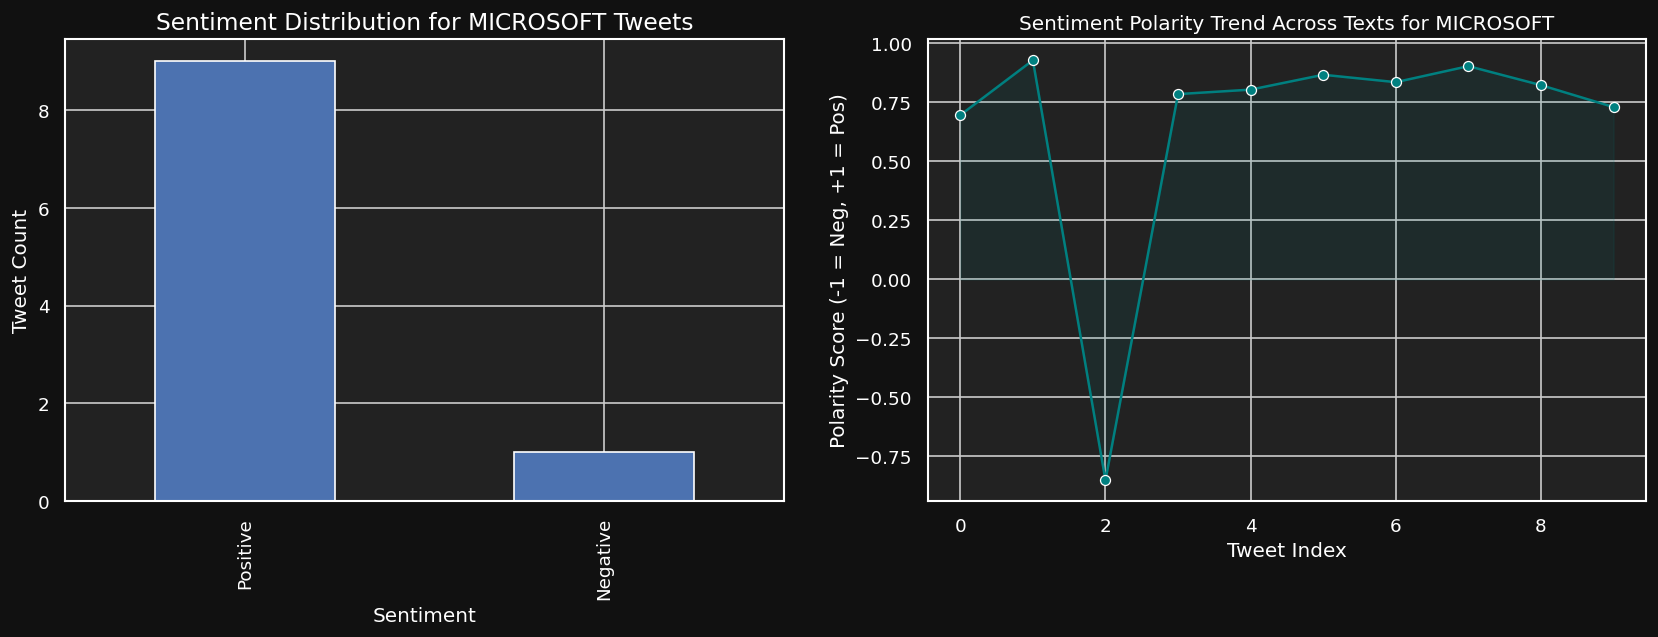

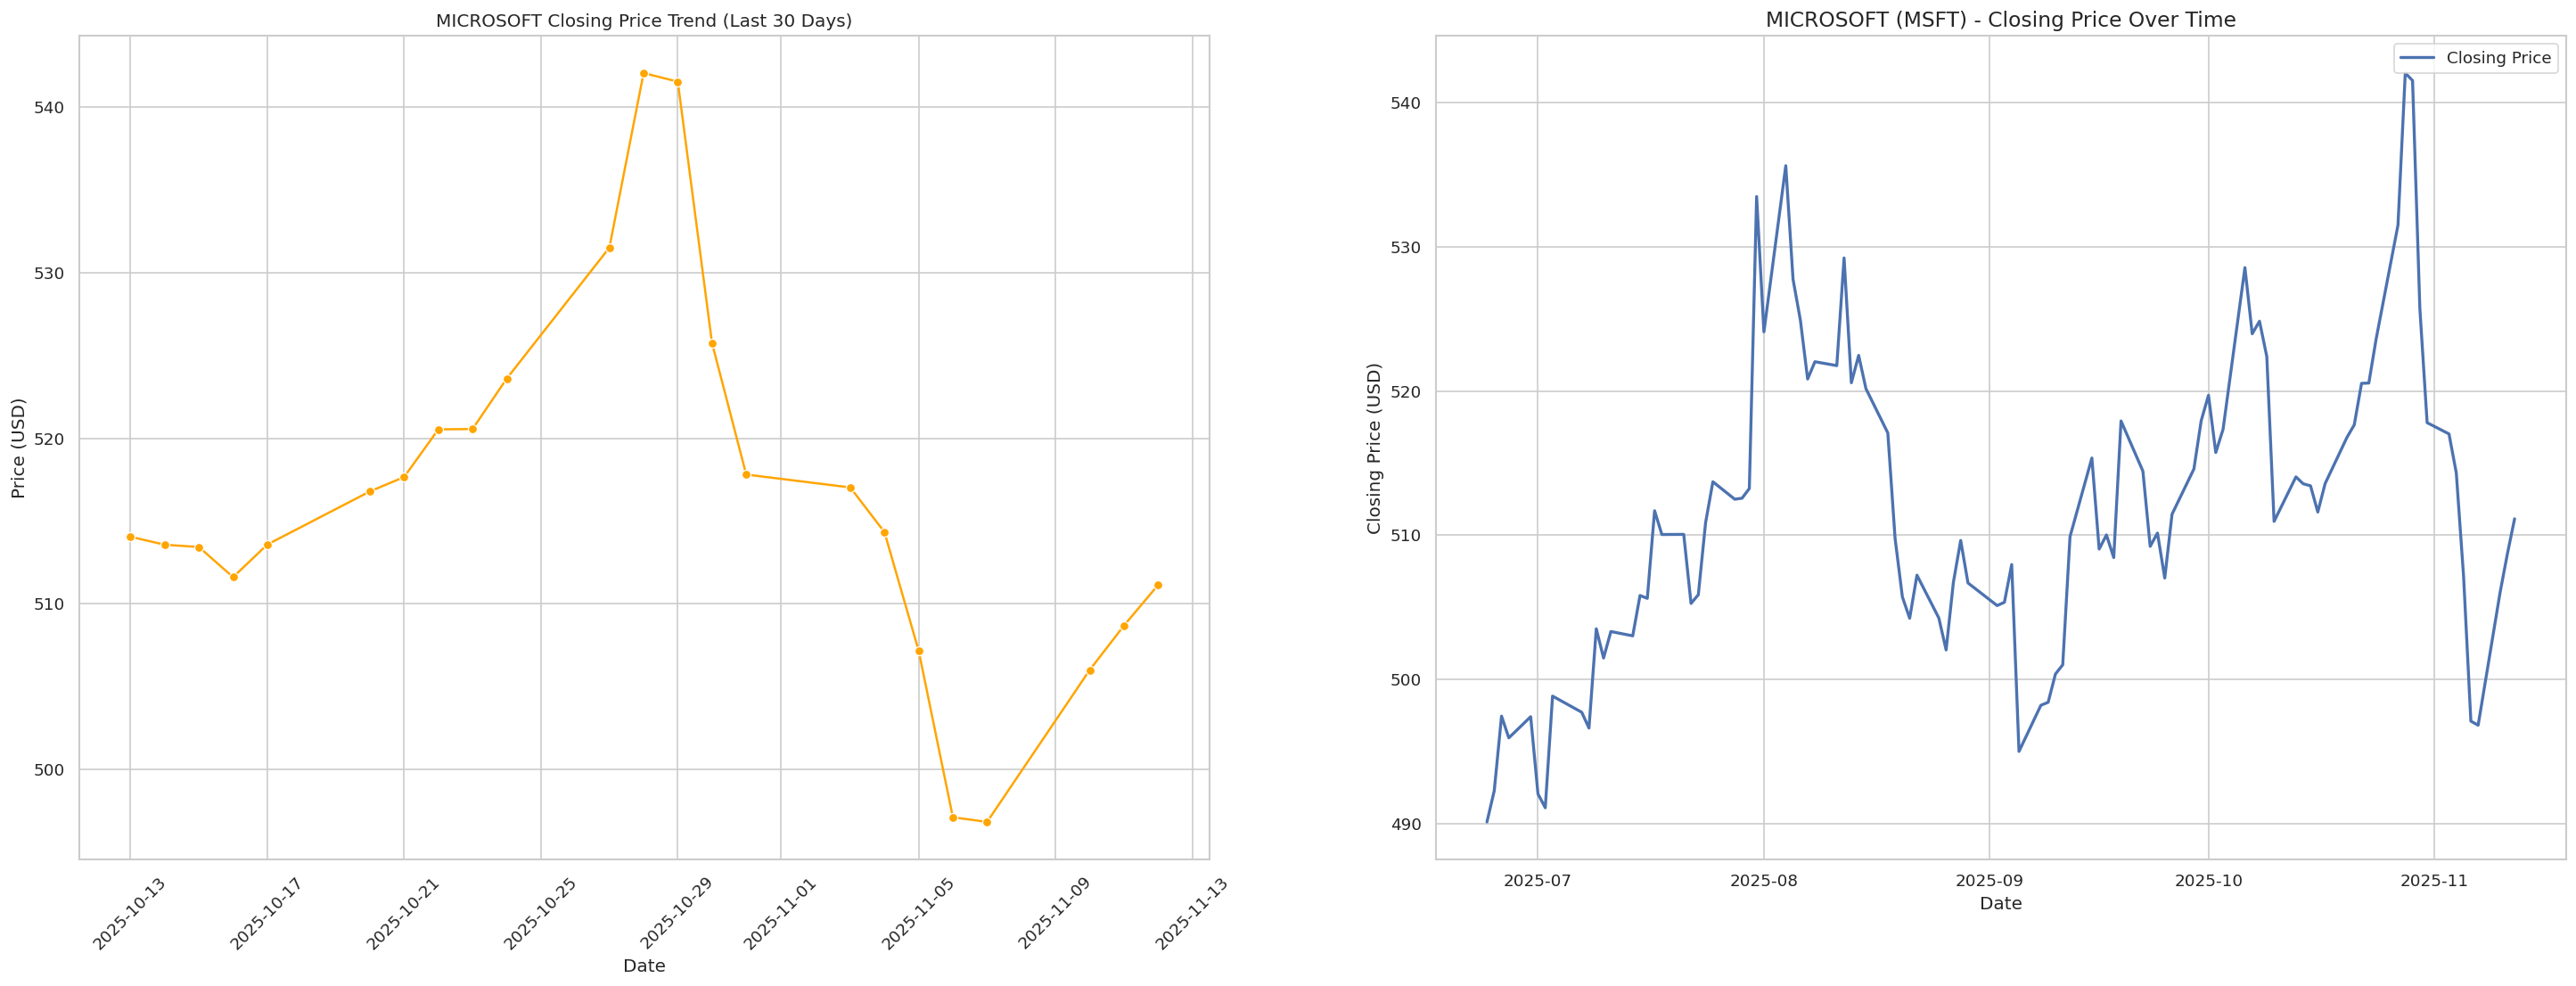

In [159]:
def dashboard(company, summary, analysis_trend, analysis_decision):
  card(company, summary)
  display(HTML(f"<h2 style='font-size:28px; margin-top:25px;'>Top 10 News Headlines for {company}:</h2>"))
  # Remove quotes around titles
  cleaned_titles = [t.strip("'\"") for t in titles]

  # Create a table
  df = pd.DataFrame({
      "Headline": cleaned_titles,
      "Link": [f'<a href="{l}" target="_blank">Read More</a>' for l in links]
  })

  display(HTML(df.to_html(escape=False, index=False)))

  fig, ax = plt.subplots(1,2, figsize=(17,5))

  # sns.countplot(data=tweets_df, x="Sentiment", hue="Sentiment", palette="viridis", legend=False, ax=ax[0])
  # if news_items:
  sent_df['sentiment'].value_counts().plot(kind='bar', edgecolor='white', ax=ax[0])
  ax[0].set_title(f"Sentiment Distribution for {company} Tweets", fontsize=14, color="white")
  ax[0].set_xlabel("Sentiment", color="white")
  ax[0].set_ylabel("Tweet Count", color="white")


  plt.fill_between(
    range(len(sent_df)),
    sent_df["polarity_score"],
    color="teal",
    alpha=0.1
  )
  sns.lineplot(x=sent_df.index, y=sent_df["polarity_score"], marker='o', linestyle='-', color='teal', ax=ax[1])
  ax[1].set_title(f"Sentiment Polarity Trend Across Texts for {company_name}", color="white")
  ax[1].set_xlabel("Tweet Index",  color="white")
  ax[1].set_ylabel("Polarity Score (-1 = Neg, +1 = Pos)",  color="white")
  ax[1].grid(True)

  # --- Apply dark theme to background and all text elements ---
  for a in ax:
      a.set_facecolor("#222")  # axis background
      a.tick_params(colors="white")  # tick label colors
      for spine in a.spines.values():  # axis borders
          spine.set_color("white")

  # --- Figure background ---
  fig.patch.set_facecolor("#111")
  plt.show()

  analysis_text = f"""
  <div style='font-size:15px;'>
    📌 Asset: {company} ({symbol})<br>
    📈 Trend Status: {analysis_trend}<br>
    ✅ Decision: {analysis_decision}
    </div>
    """

  card("AI analysis Summary", analysis_text)



  fig, ax = plt.subplots(1,2, figsize=(30,10))

  sns.lineplot(x=market_data["Date"], y=market_data["Close"], marker='o', color='orange', ax=ax[0])
  ax[0].set_title(f"{company_name} Closing Price Trend (Last 30 Days)")
  ax[0].set_xlabel("Date")
  ax[0].set_ylabel("Price (USD)")
  ax[0].tick_params(axis='x', rotation=45)


  sns.lineplot(x=data.index, y=data['4. close'], label='Closing Price', linewidth=2, ax=ax[1])
  ax[1].set_title(f"{company_name} ({symbol}) - Closing Price Over Time", fontsize=14)
  ax[1].set_xlabel("Date", fontsize=12)
  ax[1].set_ylabel("Closing Price (USD)", fontsize=12)
  plt.grid(True)
  plt.show()

dashboard(company=asset_name, summary=company_summary, analysis_trend=trend, analysis_decision=decision)

# **Slack Alerts Sender**

In [160]:
# ✅ Slack Alert Sender

import os, json, requests
from datetime import datetime

# ✅ Store your real webhook here for local testing
# (In Colab use: os.environ["SLACK_WEBHOOK_URL"] = userdata.get("SLACK_WEBHOOK_URL"))
SLACK_WEBHOOK_URL = userdata.get("SLACK_WEBHOOK_URL")
def send_slack_alert(data):
    webhook = SLACK_WEBHOOK_URL
    if not webhook:
        print("❌ Slack webhook missing.")
        return

    # ✅ Slack requires at least a "text" field
    payload = {
        "text": f"🚨 {data['alert_type']} for {data['company_name']} ({data['company_ticker']})",
        "blocks": [
            {
                "type": "header",
                "text": {
                    "type": "plain_text",
                    "text": f"{data['alert_type']} — {data['company_ticker']}"
                }
            },
            {
                "type": "section",
                "fields": [
                    {"type": "mrkdwn", "text": f"*Company:*\n{data['company_name']}"},
                    {"type": "mrkdwn", "text": f"*Ticker:*\n{data['company_ticker']}"},
                    # {"type": "mrkdwn", "text": f"*Price:*\n${data['current_price']:.2f}"},
                    {"type": "mrkdwn", "text": f"*Sentiment:*\n{data['sentiment_score']:.2f}"},
                    # {"type": "mrkdwn", "text": f"*Daily Change:*\n{data['daily_change_percent']:.2f}%"},
                    {"type": "mrkdwn", "text": f"*Volatility:*\n{data['volatility_metric']}"},
                ]
            },
            {"type": "divider"},
            {
                "type": "section",
                "text": {
                    "type": "mrkdwn",
                    "text": f"*Recommendation:*\n{data['strategic_action']}"
                }
            },
            {
                "type": "context",
                "elements": [
                    {"type": "mrkdwn", "text": f"Signal Time: {data['signal_time']}"}
                ]
            }
        ]
    }

    r = requests.post(
        webhook,
        data=json.dumps(payload),
        headers={"Content-Type": "application/json"}
    )

    if r.status_code == 200:
        print("✅ Slack alert sent successfully!")
    else:
        print("❌ Slack Error:", r.text)
def build_alert(company, ticker, title, body, sentiment):
    return {
        "company_name": company,
        "company_ticker": ticker,
        "alert_type": title,
        "strategic_action": body,
        # "current_price": price,
        "sentiment_score": sentiment,
        # "daily_change_percent": change,
        # "daily_change_absolute": round(price * (change / 100), 2),
        "volatility_metric": "Medium",
        "signal_time": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }


In [161]:
# day_change = ((df.y.iloc[-1] - df.y.iloc[-2]) / df.y.iloc[-2]) * 100
pos_ratio = (sent_df["sentiment"] == "Positive").mean()
neg_ratio = (sent_df["sentiment"] == "Negative").mean()

if pos_ratio > 0.60:
    alert = build_alert(
        company=company_name,
        ticker=symbol,
        title="📈 Bullish Sentiment Detected",
        body=f"{company_name} shows strong positive sentiment ({pos_ratio*100:.1f}%).",
        # price=float(df.y.iloc[-1]),
        sentiment=float(pos_ratio),
        # change=float(day_change)
    )
    send_slack_alert(alert)
elif neg_ratio > 0.60:
    alert = build_alert(
        company=company_name,
        ticker=symbol,
        title="📉 Bearish Sentiment Detected",
        body=f"{company_name} shows strong *negative* sentiment ({neg_ratio*100:.1f}%). "
             f"Consider risk management or hedging strategies.",
        # price=float(df.y.iloc[-1]),
        sentiment=float(-neg_ratio),  # negative for clarity if you want
        # change=float(day_change)
    )
    send_slack_alert(alert)
else:
    print("No Slack alert triggered.")


✅ Slack alert sent successfully!
